In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler #para normalizar los valores
from copy import deepcopy

In [3]:
def GraficarNodos(grafo_nacional, grafos_dominio, dominio_encoder, metricas_sorted, titulo, cmap=plt.cm.Blues, n_rows=None, nodes=None):
    nac = deepcopy(grafo_nacional)
    dom = deepcopy(grafos_dominio)
    positions = []
    if nodes != None:
        e = [e for e in nac.nodes if e not in nodes]
        nac.remove_nodes_from(e)
        for g in range(3):
            dom[g].remove_nodes_from(e)
            positions.append(nx.spring_layout(dom[g], seed=5))
        positions.append(nx.spring_layout(nac, seed=5))
    elif n_rows != None:
        metricas_sorted = metricas_sorted.head(n_rows)
        nac.remove_nodes_from([e for e in nac.nodes if e not in list(metricas_sorted['nacional'])])
        for g in range(3):
            dom[g].remove_nodes_from([e for e in dom[g].nodes if e not in list(metricas_sorted[f'dom_{g}'])])
            positions.append(nx.spring_layout(dom[g], seed=5))
        positions.append(nx.spring_layout(nac, seed=5))
    else:
        positions.append(nx.spring_layout(nac, seed=5))
        positions *= 4
    
    fig, axs = plt.subplots(2, 2, figsize=(30, 15))
    
    for g in range(3): #por cada dominio
        #pos = nx.spring_layout(dom[g], seed=5)
        nx.draw_networkx_nodes( dom[g], positions[g], node_size=600, cmap=cmap,
                               node_color=[metricas_sorted.loc[metricas_sorted[f'dom_{g}']==col, f'dom_{g}'].index[0] for col in dom[g].nodes], 
                               ax=axs[g//2, g%2])
        nx.draw_networkx_labels(dom[g], positions[g], ax=axs[g//2, g%2])
        nx.draw_networkx_edges( dom[g], positions[g], edgelist=dom[g].edges(data='weight'), width=2,
                                node_size=600,
                                edge_color=[plt.cm.Greys(e[2]) for e in dom[g].edges(data='weight')], 
                                ax=axs[g//2, g%2])
        axs[g//2, g%2].set_title(f'Dominio {dominio_encoder[g]}', fontsize=15)

    ###NACIONAL###
    #pos = nx.spring_layout(nac, seed=5)
    nx.draw_networkx_nodes(nac, positions[-1], node_size=600, cmap=cmap,
                               node_color=[metricas_sorted.nacional[metricas_sorted['nacional']==col].index[0] for col in nac.nodes], 
                               ax=axs[1, 1])
    nx.draw_networkx_labels(nac, positions[-1], ax=axs[1, 1])
    nx.draw_networkx_edges(nac, positions[-1], edgelist=nac.edges(data='weight'), width=2,
                           node_size=600,
                           edge_color=[plt.cm.Greys(e[2]) for e in nac.edges(data='weight')], 
                           ax=axs[1, 1])
    axs[1, 1].set_title(f'Nacional', fontsize=15)

    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9,
                        wspace=0.02, hspace=0.2)
    
    cbar = fig.colorbar(plt.cm.ScalarMappable(norm=None, cmap=cmap), ax=axs.ravel().tolist(), shrink=0.85, ticks=[0, 0.5, 1])
    cbar.set_ticklabels(['bajo', 'medio', 'alto'])

    fig.suptitle(titulo, fontsize=24)
    plt.show()
    return


In [4]:
dominio_encoder = {0:'Semi urbano', 1:'Rural', 2:'Urbano'}

## Cargar datos

In [5]:
df = pd.read_csv('data/pesos_nac.csv', na_values=[np.nan,0], index_col='Unnamed: 0')
#df.set_index(df.columns, inplace=True)

In [6]:
df.max().loc[df.max()>1]

FOCOS               2.536630
PAREJA_GANANCIAS    7.037191
dtype: float64

In [7]:
df.min().loc[df.min()<-1]

Series([], dtype: float64)

In [8]:
pesos_dominios = []
for i in range(3):
    print(f'\nAhora es el dominio {dominio_encoder[i]}')
    pesos = pd.read_csv(f'data/pesos_dom_{i}.csv', na_values=[np.nan,0], index_col='Unnamed: 0')
    print(pesos.max().loc[pesos.max()>1])
    print(pesos.min().loc[pesos.min()<-1])
    pesos_dominios.append(pesos)


Ahora es el dominio Semi urbano
PAREJA_CUANTO_APORTA_GASTO    1.546152
dtype: float64
Series([], dtype: float64)

Ahora es el dominio Rural
PAREJA_GANANCIAS    12.966407
dtype: float64
Series([], dtype: float64)

Ahora es el dominio Urbano
FOCOS                         2.486152
PAREJA_GANANCIAS              2.588718
PAREJA_CUANTO_APORTA_GASTO    1.416543
dtype: float64
Series([], dtype: float64)


In [9]:
-2.973241e-04,  1.480415e+00

(-0.0002973241, 1.480415)

In [10]:
df.shape

(43, 43)

## Crear grafos

Nacional

In [11]:
G_2 = nx.empty_graph(0, nx.MultiDiGraph()) #initialize an empty weighted directed graph

In [12]:
for row in df.index:
    for col in df.columns:
        if not np.isnan(df.loc[row, col]):
            G_2.add_edge(row, col, weight=df.loc[row, col])

Dominio

In [13]:
#inicializo lista de grafos vacios
dominio = [nx.empty_graph(0, nx.MultiDiGraph()), nx.empty_graph(0, nx.MultiDiGraph()), nx.empty_graph(0, nx.MultiDiGraph())]

In [14]:
for i in range(3):
    #creo las aristas dirigidas pesadas del grafo
    for row in pesos_dominios[i].index:
        for col in pesos_dominios[i].columns:
            if not np.isnan(pesos_dominios[i].loc[row, col]):
                dominio[i].add_edge(row, col, weight=pesos_dominios[i].loc[row, col])

### Visualizar

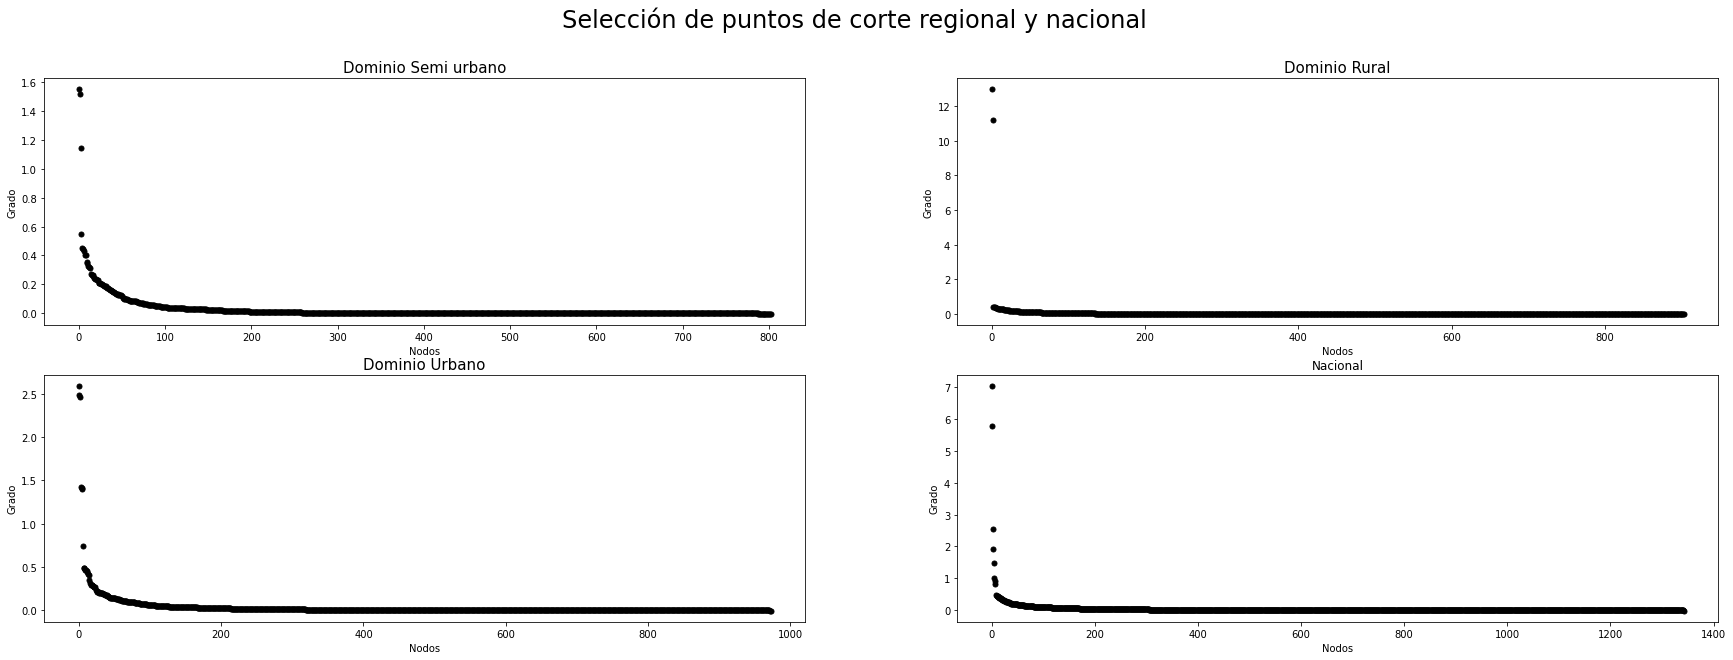

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(30, 10))

for g in range(3):
    grados = sorted([i[2] for i in dominio[g].edges(data='weight')])
    axs[g//2, g%2].plot(grados[::-1], '.k', markersize=10)
    axs[g//2, g%2].set_title(f'Dominio {dominio_encoder[g]}', fontsize=15)
    axs[g//2, g%2].set(xlabel='Nodos', ylabel='Grado')
    

###NACIONAL###
#grafico el peso de las aristas
g = -1
grados = sorted([i[2] for i in G_2.edges(data='weight')])
axs[1, 1].plot(grados[::-1], '.k', markersize=10)
axs[1, 1].set_title(f'Nacional')
axs[1, 1].set(xlabel='Nodos', ylabel='Grado')

fig.suptitle('Selección de puntos de corte regional y nacional', fontsize=24)
plt.show()

## Crear grafos

Nacional

In [16]:
G_2 = nx.empty_graph(0, nx.MultiDiGraph()) #initialize an empty weighted directed graph

In [17]:
df = pd.read_csv('data/pesos_nac.csv', na_values=[np.nan, 0], index_col='Unnamed: 0')
df = df.abs()
######columnas = df.columns #obtengo nombres de columnas
######df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=columnas, index=columnas) #normalizo y hago dataset (no funciona)
for col in df.max().loc[df.max()>1].index: #normalizo las columnas con valores mayores al rango (-1,1)
    df.loc[col, col] = -(df[col].max())
    df[col] = MinMaxScaler().fit_transform(np.array(df[col]).reshape(-1, 1))
    df.loc[col, col] = np.nan

In [18]:
for row in df.index:
    for col in df.columns:
        if not np.isnan(df.loc[row, col]) and (df.loc[row, col] > 0):
            G_2.add_edge(row, col, weight=df.loc[row, col])

Dominio

In [19]:
#inicializo lista de grafos vacios
dominio = [nx.empty_graph(0, nx.MultiDiGraph()), nx.empty_graph(0, nx.MultiDiGraph()), nx.empty_graph(0, nx.MultiDiGraph())]

In [20]:
for i in range(3):
    #cargo dataset
    pesos = pd.read_csv(f'data/pesos_dom_{i}.csv', na_values=[np.nan, 0], index_col='Unnamed: 0')
    pesos = pesos.abs()
    for col in pesos.max().loc[pesos.max()>1].index: #normalizo las columnas con valores mayores al rango (-1,1)
        pesos.loc[col, col] = -(pesos[col].max())
        pesos[col] = MinMaxScaler().fit_transform(np.array(pesos[col]).reshape(-1, 1))
        pesos.loc[col, col] = np.nan
    
    #creo las aristas dirigidas pesadas del grafo
    for row in pesos.index:
        for col in pesos.columns:
            if not np.isnan(pesos.loc[row, col]) and (df.loc[row, col] > 0):
                dominio[i].add_edge(row, col, weight=pesos.loc[row, col])

## Elegir _cut point_

In [21]:
cut_point = [0.045, 0.048, 0.06, 0.1]

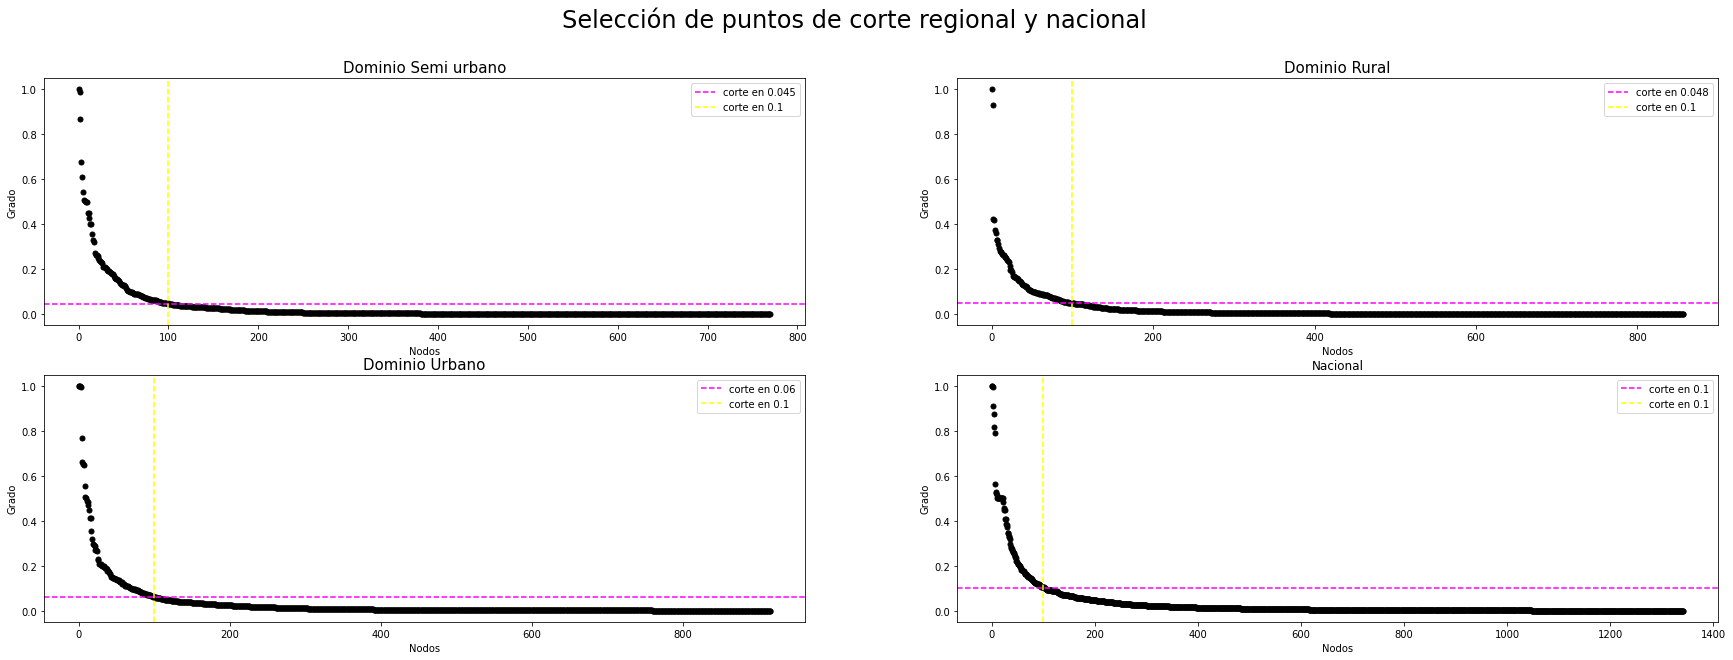

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(30, 10))

for g in range(3):
    grados = sorted([i[2] for i in dominio[g].edges(data='weight')])
    axs[g//2, g%2].plot(grados[::-1], '.k', markersize=10)
    axs[g//2, g%2].axhline(y=cut_point[g], color='fuchsia', ls='--', label=f'corte en {cut_point[g]}')
    axs[g//2, g%2].axvline(x=100, color='yellow', ls='--', label=f'corte en {cut_point[-1]}')
    axs[g//2, g%2].legend(loc='upper right')
    axs[g//2, g%2].set_title(f'Dominio {dominio_encoder[g]}', fontsize=15)
    axs[g//2, g%2].set(xlabel='Nodos', ylabel='Grado')
    

###NACIONAL###
#grafico el peso de las aristas
g = -1
grados = sorted([i[2] for i in G_2.edges(data='weight')])
axs[1, 1].plot(grados[::-1], '.k', markersize=10)
axs[1, 1].axhline(y=cut_point[-1], color='fuchsia', ls='--', label=f'corte en {cut_point[-1]}')
axs[1, 1].axvline(x=100, color='yellow', ls='--', label=f'corte en {cut_point[-1]}')
axs[1, 1].legend(loc='upper right')
axs[1, 1].set_title(f'Nacional')
axs[1, 1].set(xlabel='Nodos', ylabel='Grado')

fig.suptitle('Selección de puntos de corte regional y nacional', fontsize=24)
plt.show()

**Punto de corte**

|dominio  | corte |
|:-------:|:-----:|
|0        |0.38   |
|1        |0.4    |
|2        |0.4    |
|nacional |0.5    |

## Eliminar las aristas con los valores menores a los puntos de corte

### Nacional

In [23]:
le_ids = list(e[:2] for e in filter(lambda e: e[2] <= cut_point[-1], (e for e in G_2.edges.data('weight'))))
G_2.remove_edges_from(le_ids)

### Dominio

In [24]:
for i in range(3):
    le_ids = list(e[:2] for e in filter(lambda e: e[2] <= cut_point[i], (e for e in dominio[i].edges.data('weight'))))
    dominio[i].remove_edges_from(le_ids)

### Visualizar

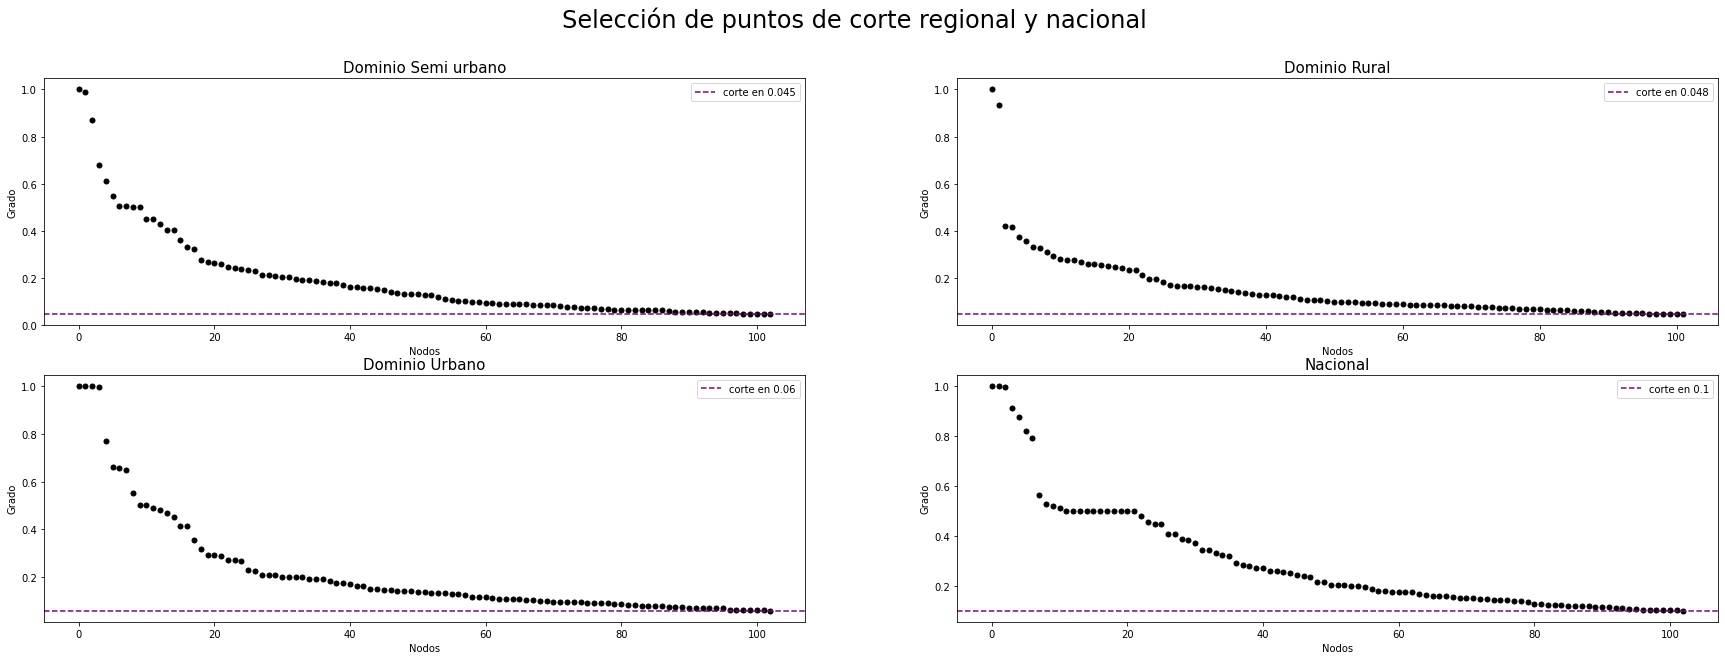

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(30, 10))

for g in range(3):
    grados = sorted([i[2] for i in dominio[g].edges(data='weight')])
    axs[g//2, g%2].plot(grados[::-1], '.k', markersize=10)
    axs[g//2, g%2].axhline(y=cut_point[g], color='purple', ls='--', label=f'corte en {cut_point[g]}')
    axs[g//2, g%2].legend(loc='upper right')
    axs[g//2, g%2].set_title(f'Dominio {dominio_encoder[g]}', fontsize=15)
    axs[g//2, g%2].set(xlabel='Nodos', ylabel='Grado')
    

###NACIONAL###
#grafico el peso de las aristas
g = -1
grados = sorted([i[2] for i in G_2.edges(data='weight')])
axs[1, 1].plot(grados[::-1], '.k', markersize=10)
axs[1, 1].axhline(y=cut_point[g], color='purple', ls='--', label=f'corte en {cut_point[g]}')
axs[1, 1].legend(loc='upper right')
axs[1, 1].set_title(f'Nacional', fontsize=15)
axs[1, 1].set(xlabel='Nodos', ylabel='Grado')

fig.suptitle('Selección de puntos de corte regional y nacional', fontsize=24)
plt.show()

# Metricas

Un dataset por cada metrica (centralidades de grado, pagerank y betweenness de entrada y salida). En un principio son 4.

Dos variantes:
 - Cada columna es un dataset distinto (regiones y nacional siendo 8 en total) y cada fila es una variable de endireh.
 - Una función que me regrese el dataset con los primeros n mayores valores en la columnas pero con el nombre de la variable, no el valor.


## Pagerank

In [26]:
df.columns

Index(['CVE_ENT', 'DOMINIO', 'SITUACION_CONYUGAL', 'MATERIAL_PISOS',
       'CUARTOS_DORMIR', 'CUARTOS_TOTAL', 'FOCOS', 'AGUA', 'DRENAJE',
       'NUM_RESIDENTES', 'NUM_HOGARES', 'BIENES_DE_VIVIENDA', 'PAREN', 'EDAD',
       'RES_MADRE', 'RES_PADRE', 'ESCOLARIDAD', 'GRADO_ESCOLAR', 'ALFABETISMO',
       'ASISTENCIA_ESC', 'PERT_INDIGENA', 'LENG_INDIGENA',
       'VERIF_SITUACION_PAREJA', 'ENTREVISTADA_TRABAJA', 'PAREJA_TRABAJA',
       'PAREJA_GANANCIAS', 'PAREJA_GANANCIAS_FRECUENCIA',
       'PAREJA_APORTA_PARA_GASTO', 'PAREJA_CUANTO_APORTA_GASTO',
       'LIBERTAD_USAR_DINERO', 'FUENTES_DE_DINERO', 'PROPIEDADES_DEL_HOGAR',
       'NUM_EMBARAZOS', 'NACIO_VIV', 'NACIO_MUERT', 'ABORTO', 'ANIO_PARTO',
       'MES_PARTO', 'DONDE_ATENDIO_PARTO', 'P10_8_abuso', 'P10_8_atencion',
       'SERVICIOS_MEDICOS_AFILIADA', 'DONDE_CONSULTAS_PRENATALES'],
      dtype='object')

In [27]:
pagerank_values = pd.DataFrame(index=df.columns)
pagerank_ranking = pd.DataFrame(index=df.columns)
pagerank_sorted = pd.DataFrame()

In [28]:
pagerank_values['nacional'] = [nx.pagerank_numpy(G_2)[pr] for pr in df.columns] 
pagerank_ranking['nacional'] = 0
for i,tupla in enumerate(sorted(nx.pagerank_numpy(G_2).items(), key=lambda x: x[1], reverse=True)):
    pagerank_ranking.loc[tupla[0],'nacional'] = i
pagerank_sorted['nacional'] = [k for k,v in sorted(nx.pagerank_numpy(G_2).items(), key=lambda x: x[1], reverse=True)]

for g in range(3):
    pagerank_values[f'dom_{g}'] = np.insert([nx.pagerank_numpy(dominio[g])[pr] for pr in pesos.columns], 1, np.nan)
    
    pagerank_ranking[f'dom_{g}'] = 0
    for i,tupla in enumerate(sorted(nx.pagerank_numpy(dominio[g]).items(), key=lambda x: x[1], reverse=True)):
        pagerank_ranking.loc[tupla[0],f'dom_{g}'] = i+1
    
    pagerank_sorted[f'dom_{g}'] = np.insert([k for k,v in sorted(nx.pagerank_numpy(dominio[g]).items(), key=lambda x: x[1], reverse=True)], 1, np.nan)

#pagerank_values.to_csv(f'data/pagerank_values.csv')
#pagerank_ranking.to_csv(f'data/pagerank_ranking.csv')
#pagerank_sorted.to_csv(f'data/pagerank_sorted.csv', index=False)

In [29]:
pagerank_sorted.head(10)

,nacional,dom_0,dom_1,dom_2
0,PAREJA_GANANCIAS,PAREJA_CUANTO_APORTA_GASTO,PAREN,ENTREVISTADA_TRABAJA
1,PAREJA_CUANTO_APORTA_GASTO,nan,nan,nan
2,ESCOLARIDAD,PAREJA_APORTA_PARA_GASTO,BIENES_DE_VIVIENDA,LIBERTAD_USAR_DINERO
3,MES_PARTO,PAREN,PROPIEDADES_DEL_HOGAR,CUARTOS_DORMIR
4,PAREJA_GANANCIAS_FRECUENCIA,GRADO_ESCOLAR,GRADO_ESCOLAR,CUARTOS_TOTAL
5,NUM_EMBARAZOS,ESCOLARIDAD,ESCOLARIDAD,ESCOLARIDAD
6,GRADO_ESCOLAR,P10_8_abuso,P10_8_abuso,GRADO_ESCOLAR
7,CUARTOS_DORMIR,P10_8_atencion,P10_8_atencion,P10_8_abuso
8,SERVICIOS_MEDICOS_AFILIADA,RES_PADRE,RES_MADRE,P10_8_atencion
9,PAREJA_TRABAJA,RES_MADRE,CVE_ENT,PAREJA_CUANTO_APORTA_GASTO


## Centralidad de grado

In [30]:
degree_centrality_values = pd.DataFrame(index=df.columns)
degree_centrality_ranking = pd.DataFrame(index=df.columns)
degree_centrality_sorted = pd.DataFrame()

In [31]:
degree_centrality_values['nacional'] = [nx.degree_centrality(G_2)[dc] for dc in df.columns]
degree_centrality_ranking['nacional'] = 0
for i,tupla in enumerate(sorted(nx.degree_centrality(G_2).items(), key=lambda x: x[1], reverse=True)):
    degree_centrality_ranking.loc[tupla[0],'nacional'] = i
degree_centrality_sorted['nacional'] = [k for k,v in sorted(nx.degree_centrality(G_2).items(), key=lambda x: x[1], reverse=True)]

for g in range(3):
    degree_centrality_values[f'dom_{g}'] = np.insert([nx.degree_centrality(dominio[g])[dc] for dc in pesos.columns], 1, np.nan)
    
    degree_centrality_ranking[f'dom_{g}'] = 0
    for i,tupla in enumerate(sorted(nx.degree_centrality(dominio[g]).items(), key=lambda x: x[1], reverse=True)):
        degree_centrality_ranking.loc[tupla[0],f'dom_{g}'] = i+1
    
    degree_centrality_sorted[f'dom_{g}'] = np.insert([k for k,v in sorted(nx.degree_centrality(dominio[g]).items(), key=lambda x: x[1], reverse=True)], 1, np.nan)

#degree_centrality_values.to_csv(f'data/degree_centrality_values.csv')
#degree_centrality_ranking.to_csv(f'data/degree_centrality_ranking.csv')
#degree_centrality_sorted.to_csv(f'data/degree_centrality_sorted.csv', index=False)

In [39]:
degree_centrality_sorted.head(10)

,nacional,dom_0,dom_1,dom_2
0,CVE_ENT,CVE_ENT,CVE_ENT,CVE_ENT
1,PAREJA_GANANCIAS,nan,nan,nan
2,MES_PARTO,PAREN,PAREN,PAREN
3,FOCOS,NUM_RESIDENTES,MES_PARTO,LIBERTAD_USAR_DINERO
4,ESCOLARIDAD,PAREJA_CUANTO_APORTA_GASTO,NUM_RESIDENTES,FOCOS
5,PAREJA_CUANTO_APORTA_GASTO,EDAD,EDAD,ENTREVISTADA_TRABAJA
6,DOMINIO,MES_PARTO,CUARTOS_DORMIR,PAREJA_CUANTO_APORTA_GASTO
7,CUARTOS_DORMIR,RES_PADRE,RES_MADRE,NUM_RESIDENTES
8,BIENES_DE_VIVIENDA,NACIO_VIV,RES_PADRE,PAREJA_GANANCIAS
9,CUARTOS_TOTAL,DONDE_CONSULTAS_PRENATALES,PAREJA_GANANCIAS,MES_PARTO


## Visualizar los grafos obtenidos

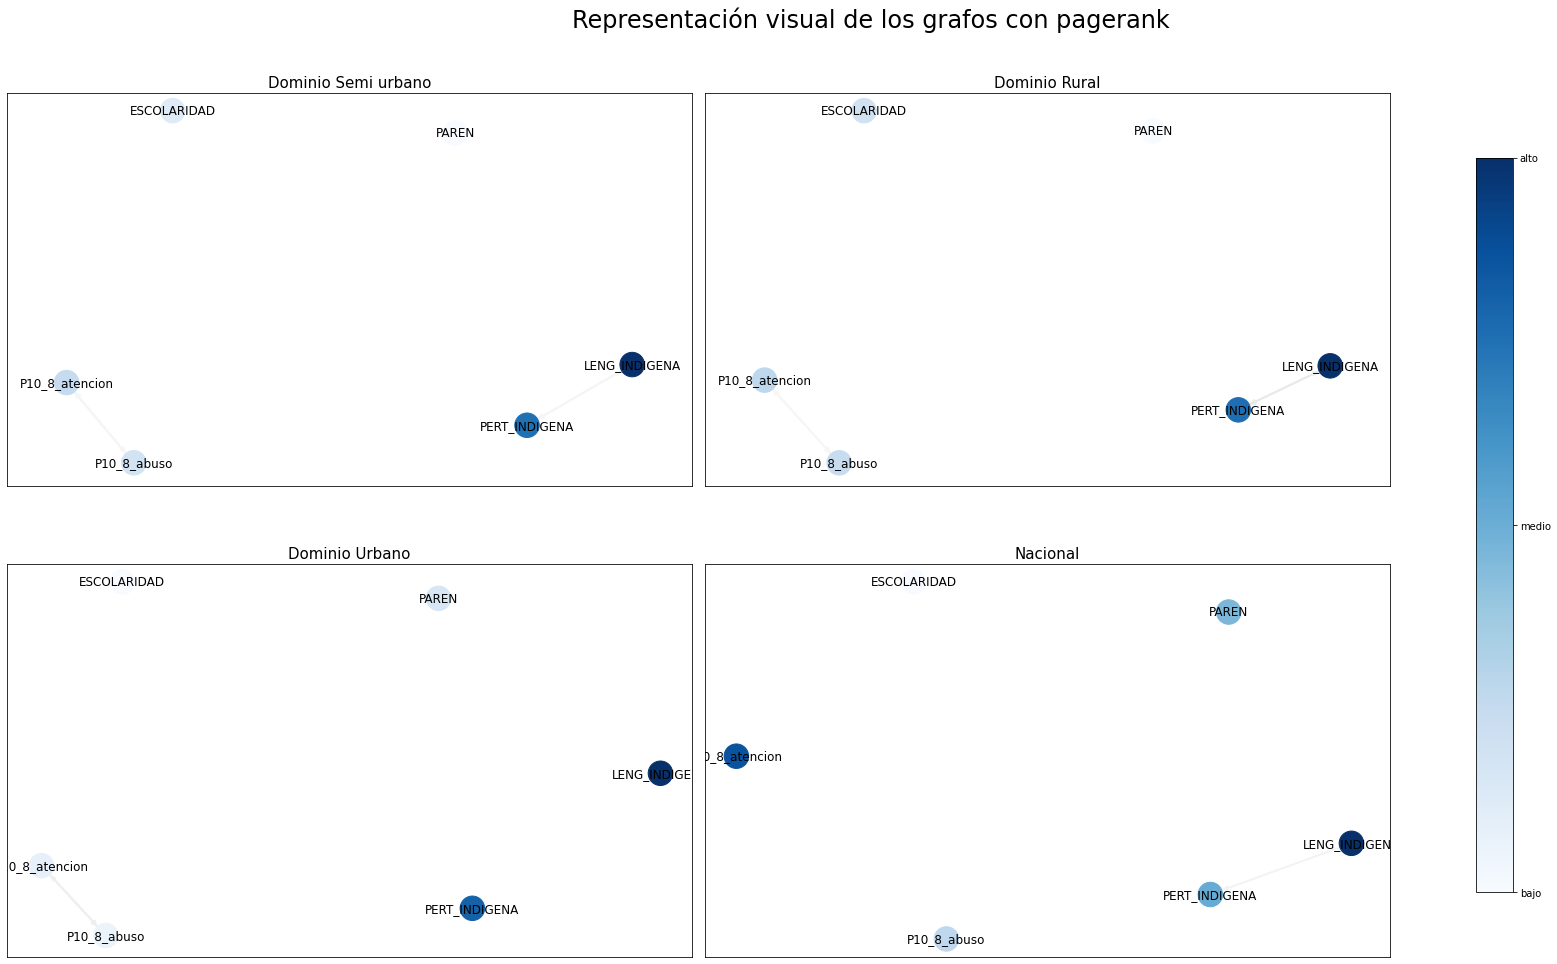

In [32]:
GraficarNodos(G_2, dominio, dominio_encoder, pagerank_sorted, 'Representación visual de los grafos con pagerank', 
              nodes=['PAREN', 'P10_8_abuso', 'P10_8_atencion', 'ESCOLARIDAD', 'GRA', 'TRABAJO', 'P2_14', 'P2_15', 'PERT_INDIGENA', 'LENG_INDIGENA', 'LENG_ESPANOL'])

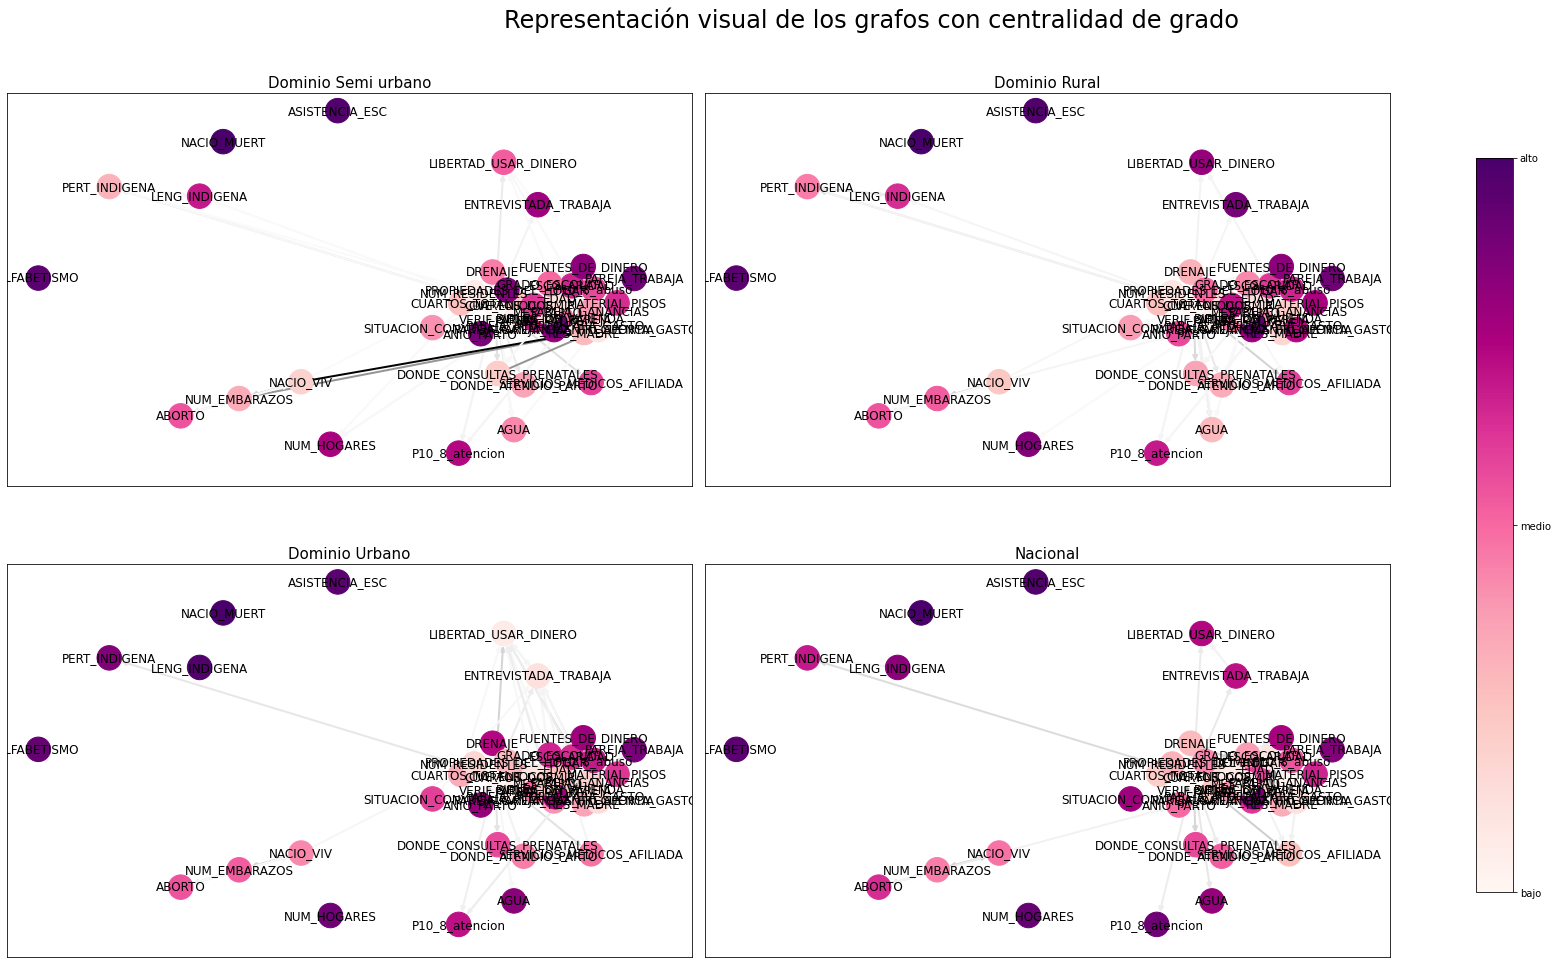

In [33]:
GraficarNodos(G_2, dominio, dominio_encoder, degree_centrality_sorted, 'Representación visual de los grafos con centralidad de grado', plt.cm.RdPu)

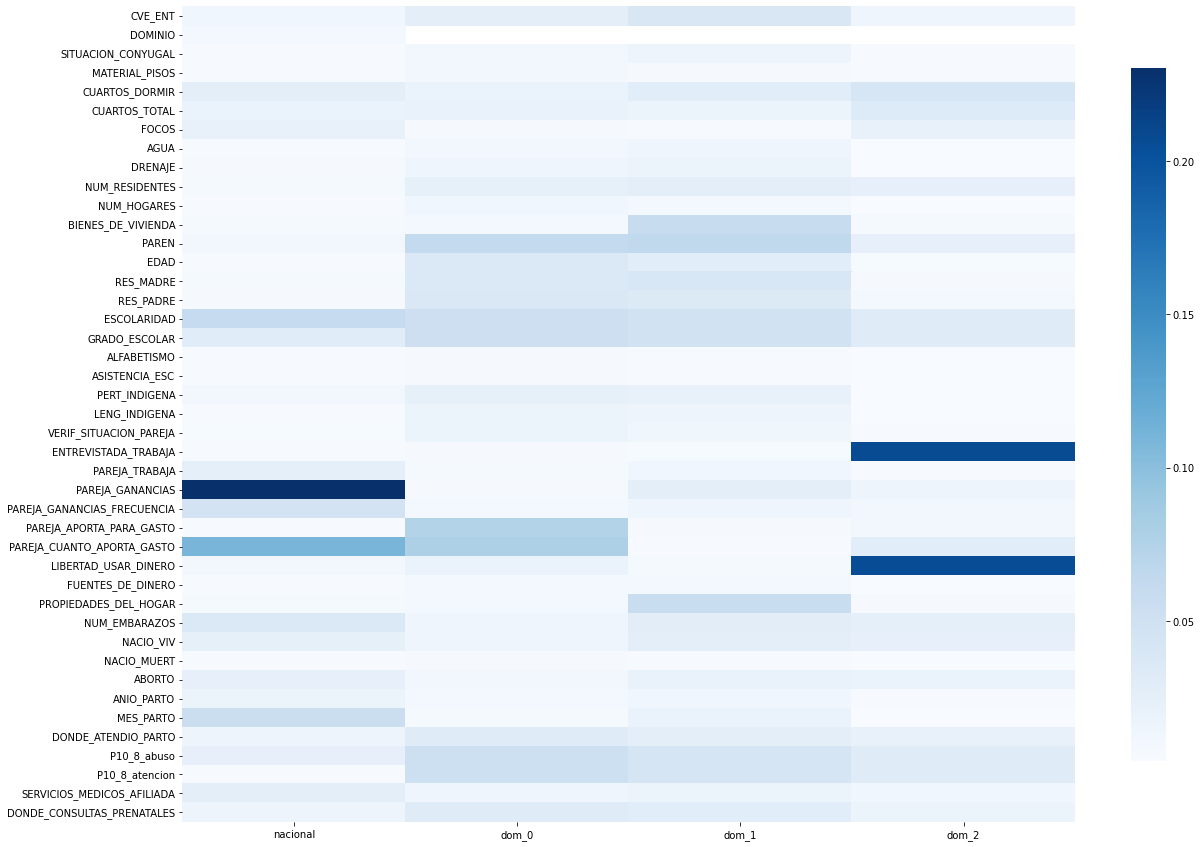

In [34]:
plt.figure(figsize=(20, 15))
sns.heatmap(pagerank_values, cmap='Blues', cbar_kws={'shrink':0.85})
plt.show()

# Comparar sube y baja de ranking

In [35]:
def comparar_cambio_ranking_dominios(df_ranking, columnas):
    """
    df_ranking: el df de rankings
    columnas:   el nombre de las columnas del df de ranking a comparar, solo 2 o se reconocerán solo las primeras 2
    """
    fluctuacion_ranking = [df_ranking.loc[i,columnas[0]] - df_ranking.loc[i,columnas[1]] for i in df_ranking.index]
    return fluctuacion_ranking

def crear_df_comparacion_nacional_con_dominios(df_ranking, col_referencia):
    df = df = pd.DataFrame(index=df_ranking.index) # crear el nuevo df con las variables como indice
    dominios_a_comparar = list(df_ranking.columns)
    dominios_a_comparar.pop(dominios_a_comparar.index(col_referencia)) #eliminar col_referencia de la lista
    
    for dom in dominios_a_comparar: 
        df[dom] = comparar_cambio_ranking_dominios(df_ranking, [col_referencia,dom])
    return df

def obtener_tamanio_traslape(df_fluctuation):
    for col in df_fluctuation.columns:
        try:
            value = df_fluctuation[col].value_counts()[0]
        except:
            value = 0
        print(f'La cantidad de variables que se mantuvieron en el mismo lugar en {col} fueron {value}')

In [36]:
print('Centralidad de grado')
degree_centrality_fluctuation = crear_df_comparacion_nacional_con_dominios(degree_centrality_ranking, 'nacional')
obtener_tamanio_traslape(degree_centrality_fluctuation)

Centralidad de grado
La cantidad de variables que se mantuvieron en el mismo lugar en dom_0 fueron 3
La cantidad de variables que se mantuvieron en el mismo lugar en dom_1 fueron 3
La cantidad de variables que se mantuvieron en el mismo lugar en dom_2 fueron 2


In [37]:
print('Pagerank')
pagerank_fluctuation = crear_df_comparacion_nacional_con_dominios(pagerank_ranking, 'nacional')
obtener_tamanio_traslape(pagerank_fluctuation)

Pagerank
La cantidad de variables que se mantuvieron en el mismo lugar en dom_0 fueron 1
La cantidad de variables que se mantuvieron en el mismo lugar en dom_1 fueron 1
La cantidad de variables que se mantuvieron en el mismo lugar en dom_2 fueron 3


In [38]:
degree_centrality_fluctuation

,dom_0,dom_1,dom_2
CVE_ENT,-1,-1,-1
DOMINIO,6,6,6
SITUACION_CONYUGAL,16,17,8
MATERIAL_PISOS,1,-4,2
CUARTOS_DORMIR,-3,1,-6
CUARTOS_TOTAL,-2,-2,-5
FOCOS,-23,-27,-1
AGUA,16,22,-1
DRENAJE,-7,-1,-19
NUM_RESIDENTES,10,9,6


# Pendientes
1. Revisar código para resolver que todos tengan el mismo grado **listo**
2. Por cada grafo obtener el histograma de grado o FI (preguntar) y elegir umbral a cortar. Todos los que esten arriba de ese umbral serán los que quedaran y los demás enlaces se borraran. **listo**
3. Obtener centralidades de grado, pagerank y betweness  y guardarlo en csv. Por region y nacional. **listo**
5. una funcion que se le da un csv y me deja las mayores n centralidades con los nombres de columnas en valor. **listo**
6. codigo de color en los nodos basado en pagerank. **listo**
7. hacer los grafos de dominio. **listo**
8. Visualizar las primeras n variables en sorted. **listo**
9. Visualizar las variables que me pasen. **listo**
10. Visualizar las aristas respecto a los pesos. **listo**
11. Comparar los grafos con la fórmula que me pasará Marisol. **listo**


### Librerías compatibles
https://scikit-network.readthedocs.io/en/latest/